# Add Extra Variables to Model Output

Now we have been through running the HRLDAS/NoahMP model with single-point and 2D regional simulations. 

In this note, we will modify the code to allow extra output variables, given the advantages in the new refactor code. For example, we will output one extra variable `BTRAN`, which is related to soil moisture and ET calculation. This `BTRAN` variable have been a local variable and not a standard output. 

## 1. `BTRAN` variable in code v4.5 and v5.0

The `BTRAN` variable, defined as the `soil water transpiration factor (0-1)`, has been a local variable in the `NOAHMP_SFLX` subroutine in `module_sf_noahmplsm.F` code. It is an important diagnostic variable for accessing soil moisture and vegetation. 

Let's say we want to output this local variable

`  REAL                  :: BTRAN  !soil water transpiration factor (0 - 1)` 

In the v4.5 code:

1. First, we would need to go into `module_sf_noahmplsm.F`, modify the above line to add `INTENT(OUT)`

2. Then, create allocatable array in the noahmp driver, `module_sf_noahmpdrv.F`, 

3. Finally, in `IO_code/module_NoahMP_hrldas_driver.F`, add output into `add_to_output subroutine`.


In the v5.0 code:

This variable is renamed as `SoilTranspFacAcc` (the renaming itself has more physical meaning than it was `BTRAN`).
And this variable is defined in `/noahmp/src/WaterVarType.F90`:

`!=== define "state" sub-type of water (water%state%variable)
  type :: state_type`
  
......
  
`real(kind=kind_noahmp) :: SoilSaturateFracAcc           ! fractional saturated area for soil moisture`

So we can follow the similar procedure as in v4.5 and output this variable in v5.0.

## 2. Define `BTRANXY` in `/noahmp/drivers/hrldas/`

### 2.1 in `NoahmpIOVarType.F90`, define `BTRANXY` as an allocatable variable for output
**L221**: `    real(kind=kind_noahmp), allocatable, dimension(:,:)    ::  BTRANXY             ! soil transpiration factor (0-1) `

### 2.2 in `NoahmpIOVarInitMod.F90`, allocate and define an initial value for `BTRANXY`
**L180**: `    if ( .not. allocated (NoahmpIO%BTRANXY)   ) allocate ( NoahmpIO%BTRANXY    (XSTART:XEND,               YSTART:YEND) ) ! soil transpiration factor (0-1) `

......

**L597**: `    NoahmpIO%BTRANXY         = 0.0`



### 2.3 Transfer in and out: from `BTRANXY` to `SoilTranspFacAcc`

**Transfer In**: `/drivers/hrldas/WaterVarInTransferMod.F90`

**L77**: `    noahmp%water%state%SoilTranspFacAcc                   = NoahmpIO%BTRANXY    (I,J)`

**Transfer Out**: `/drivers/hrldas/WaterVarOutTransferMod.F90`

**L128**: `    NoahmpIO%BTRANXY     (I,J) = noahmp%water%state%SoilTranspFacAcc`

## 3. Add `BTRANXY` to output list
In `./hrldas/IO_code/module_NoahMP_hrldas_driver.F`, `add_to_output` subroutine:

**L1120**: `               call add_to_output(NoahmpIO%BTRANXY    , "BTRANXY" , "Soil Transpiration Factor (0-1)"      , "-"                     )`

## 4. Check these modifications 
You can check above modificaitons through `git diff` command.

For example in the `./noahmp/` directory:
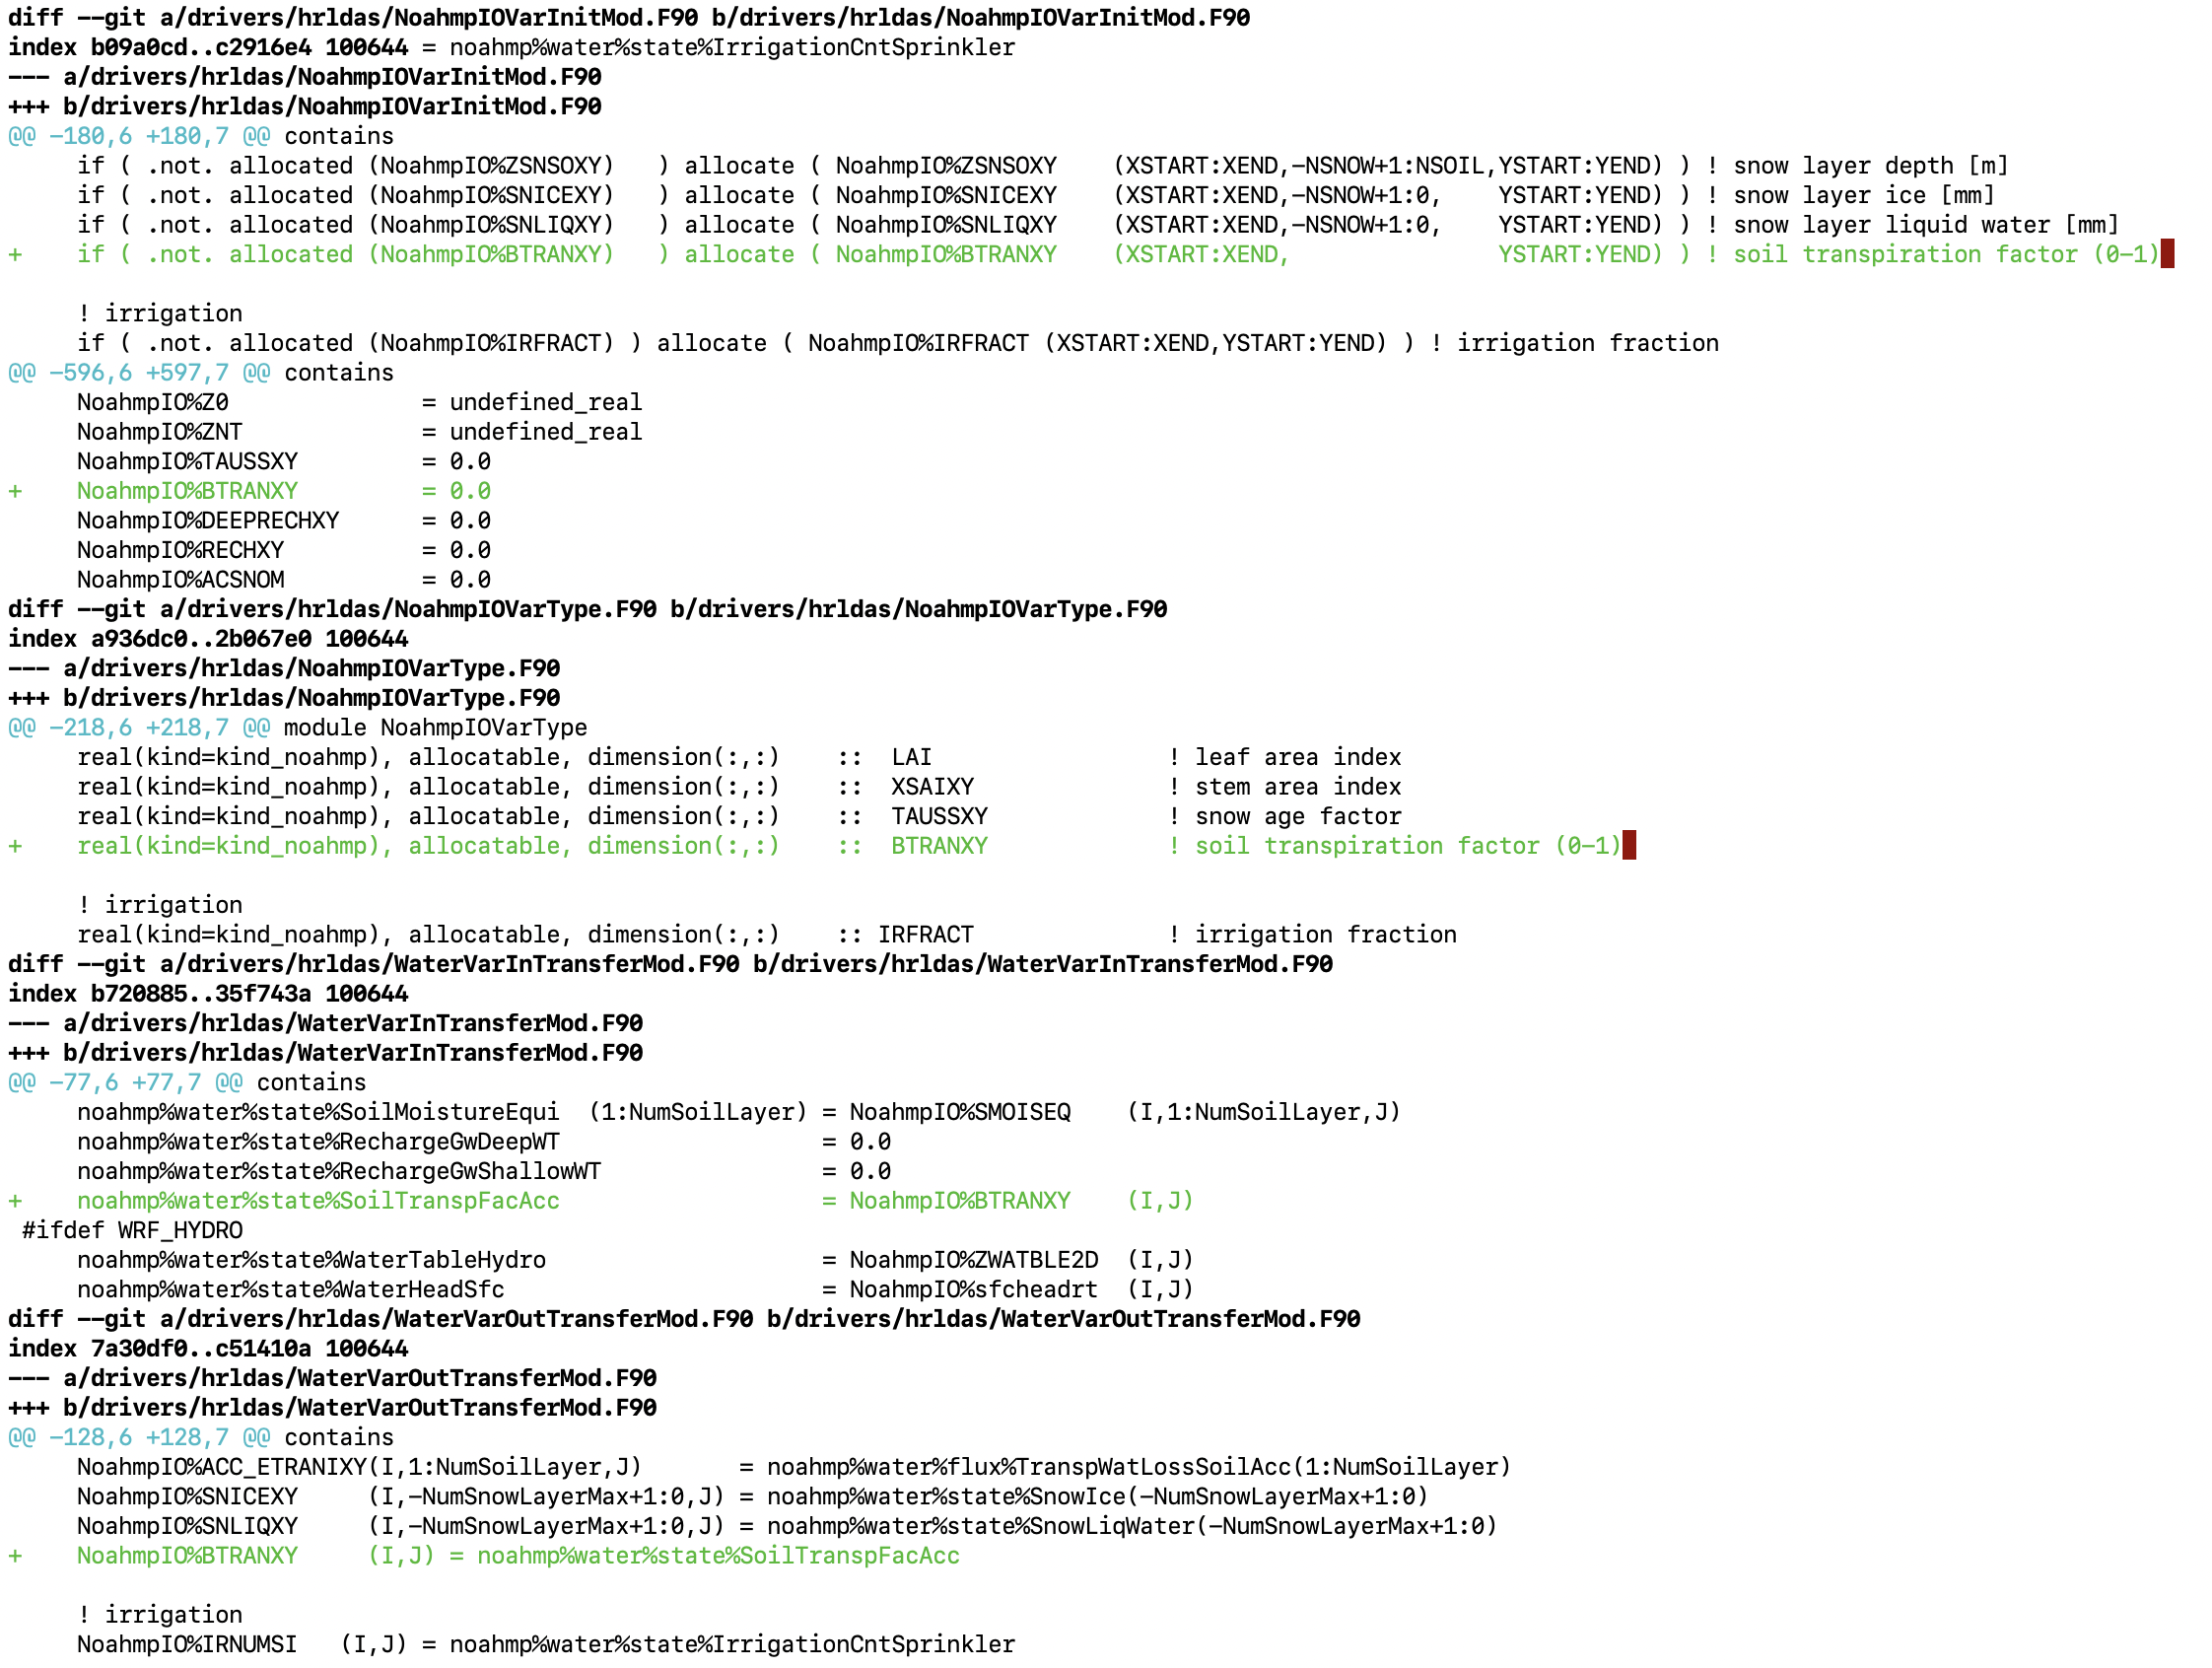

......

and in the `./hrldas/` directory:
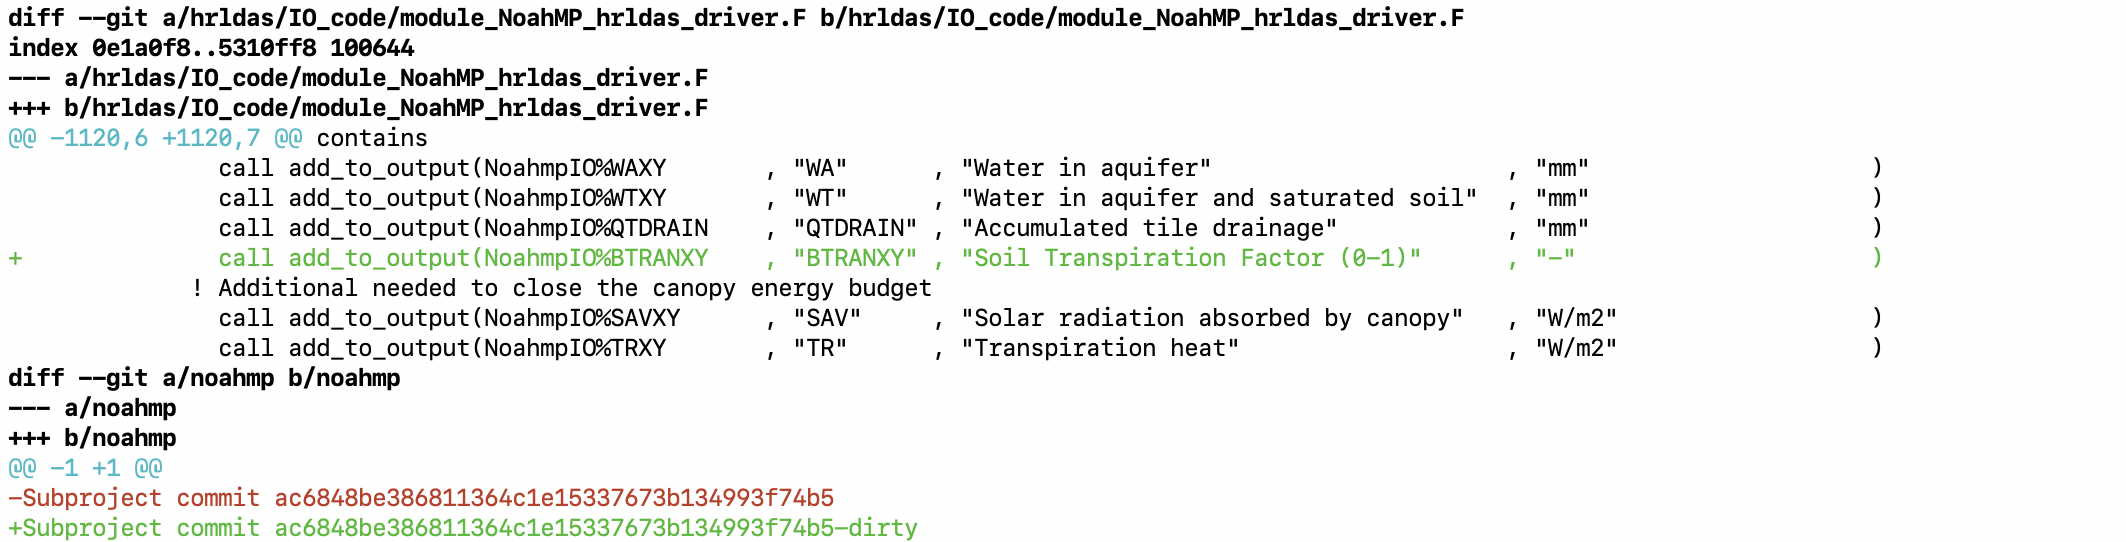

## 5. Recompile the code and check `BTRANXY` output
Again, `make` to build the modified version.

We will use the **single-point** case and exam the output `BTRAN` variable.

`cd run`

`./hrldas.exe`

`ncview 199801010030.LDASOUT_DOMAIN1 `

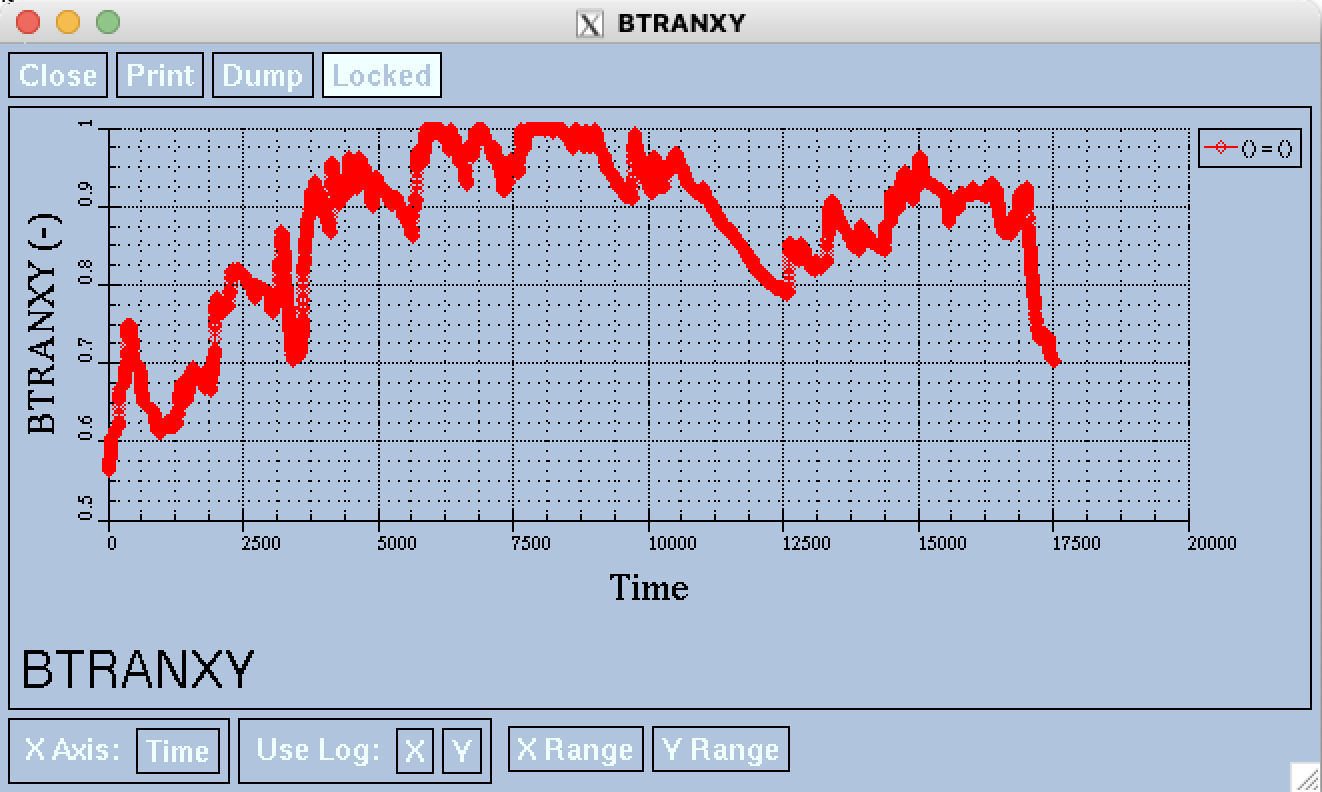

**Now you can find the `BTRANXY` variable has been successfully output!**
